# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's BipedalWalker-v2 environment.

## 1. Import the Necessary Packages

In [1]:
# render ai gym environment
#!pip install gymnasium[box2d]
import gymnasium as gym

#!pip install progressbar
#import progressbar as pb
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, defaultdict
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    print("Ipython")
    from IPython import display
else:
    print("pyvirtualdisplay")
    #!python -m pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
ion_context = plt.ion()

# install package for displaying animation
#!pip install JSAnimation
from JSAnimation.IPython_display import display_animation

from utils import *
from agents import Agent

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device from utils: ", device) 


Ipython
Using device from utils:  cuda:0


If *continuous=True* is passed, continuous actions (corresponding to the throttle of the engines) will be used and the action space will be `Box(-1, +1, (2,), dtype=np.float32)`. 

The **first coordinate** of an action determines the **throttle of the main engine**, while the **second** coordinate specifies the **throttle of the lateral boosters**. 

Given an action `np.array([main, lateral])`, the main engine will be turned off completely if **main < 0** and the throttle scales affinely from **50% to 100%** for **0 <= main <= 1** (in particular, the main engine doesn’t work with **less than 50% power**). 

Similarly, if **-0.5 < lateral < 0.5**, the lateral boosters will not fire at all. If **lateral < -0.5**, the **left booster** will fire, and if **lateral > 0.5**, the **right booster** will fire. Again, the throttle scales affinely from **50% to 100%** between **-1 and -0.5** (and **0.5 and 1**, respectively).

*gravity* dictates the gravitational constant, this is bounded to be within **0 and -12.**

If *enable_wind=True* is passed, there will be wind effects applied to the lander. The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`. **k** is set to **0.01**. **C** is sampled randomly between **-9999 and 9999**.

*wind_power* dictates the maximum magnitude of linear wind applied to the craft. The recommended value for *wind_power* is between **0.0 and 20.0**. 

*turbulence_power* dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for *turbulence_power* is between **0.0 and 2.0**.

In [2]:
#import random
r = random.choice([(random.random()*1.1 + 0.9) / 2.]*5 + [0.0])
print(r)
y = [(random.random()*1.1 + 0.9) / 2. for _ in range(10000)]
                  #    (x[0] + 0.99) / 2.] ) for _ in x]
print(min(y), max(y))

0.0
0.45008818948403323 0.9999757084703511


In [3]:
width = 1.0
for _ in range(10):
    print([ 2*width*(random.random() - 0.5) for _ in range(2)])

[-0.49241928813849234, 0.9800927838900799]
[0.18481334943564653, 0.23395428354367254]
[-0.10423636928881819, -0.880228781882157]
[-0.8918211649881991, -0.951939008880202]
[0.5034234413173042, 0.8733230139887611]
[-0.9146570342819202, -0.5657421769993201]
[-0.9032342677259153, 0.06507232963293341]
[0.9944019900795087, 0.3275822772845869]
[0.686453222507295, 0.7289121842206623]
[0.4189943985430189, 0.4760919657986693]


0 0.30005754381106864 0.9998999589495088
1 0.5000089056201795 0.999929756099825


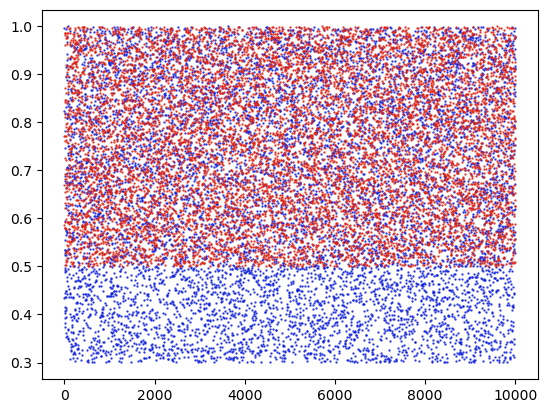

In [4]:

x = np.arange(10000)
y0=[(random.random()*1.4 + 0.6) / 2. for _ in x]
y1=[(random.random() + 1.0) / 2. for _ in x]
y=[y0,y1]
c=['#12d' , '#d21']
print("0", min(y0), max(y0))
print("1", min(y1), max(y1))
f = plt.Figure()
f.figsize=(12,2)
for yy, cc in zip(y,c):
    plt.scatter(x,yy, alpha=0.8, s=0.5, c=cc)

## 2. Instantiate the Environment

State shape:  8
Number of actions:  2
[0.47626004 0.6872073 ] -0.238 False


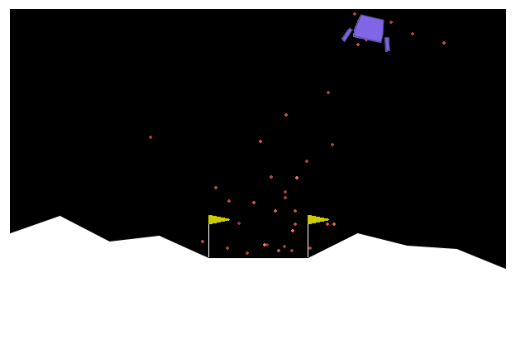

In [5]:
##### NEW GYM = GYMNASIUM
#!pip install gymnasium[box2d]
#import gymnasium as gym
discrete = False
if discrete:
    env = gym.make("LunarLander-v2", render_mode="rgb_array",    #"human",       #
                                 continuous= True, #False
                                 gravity= -9.81,
                                 enable_wind= False,
                                 wind_power= 0.,  # 20
                                 turbulence_power= 0.) # 2     
else:
    env = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array")

state, info = env.reset(seed = SEED)
for _ in range(67):
    action = env.action_space.sample() 
    state, reward, done, trun, info = env.step(action)

state_shape = env.observation_space.shape
state_size = state_shape[0]
try: action_size = env.action_space.n
except: action_size=env.action_space.shape[0]
print('State shape: ', state_size)
print('Number of actions: ', action_size)
print(action, round(reward, 3), done or trun)
plt.axis('off')
plt.imshow(pix_norm(env.render()))

In [6]:
print([k for k in gym.envs.registry.keys() if "Continuous" in k])  #.all().keys()  #.make
gym.envs.registry['LunarLanderContinuous-v2']

['MountainCarContinuous-v0', 'LunarLanderContinuous-v2']


EnvSpec(id='LunarLanderContinuous-v2', entry_point='gymnasium.envs.box2d.lunar_lander:LunarLander', reward_threshold=200, nondeterministic=False, max_episode_steps=1000, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'continuous': True}, namespace=None, name='LunarLanderContinuous', version=2)

## 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [7]:
### Initialize Agent 
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED, learn_every=4)
starting = True
check_params = False
load_weights = False

if load_weights:
    try:
        #agent.actor_local.load_state_dict(torch.load('data/highscore_actor.pth'))#, map_location=torch.device('cpu')))
        #agent.critic_local.load_state_dict(torch.load('data/highscore_critic.pth'))#, map_location=torch.device('cpu')))

        agent.actor_target.load_state_dict(torch.load('data/actor_chkpnt300.pth'))
        agent.critic_target.load_state_dict(torch.load('data/critic_chkpnt300.pth'))
    except: print("Problem loading weights.")

if check_params:
    actor_local_params = [p.detach().cpu().numpy() for p in agent.actor_local.parameters()]
    actor_target_params = [p.detach().cpu().numpy() for p in agent.actor_target.parameters()]
    critic_local_params =  [p.detach().cpu().numpy() for p in agent.critic_local.parameters()]
    critic_target_params =  [p.detach().cpu().numpy() for p in agent.critic_target.parameters()]

    print(">> Actor")
    print("Local:", actor_local_params[-1], "\nTarget:", actor_target_params[-1])
    print(actor_local_params[0]==actor_target_params[0])
    print("\n>> Critic")
    print("Local:", critic_local_params[-1], "\nTarget:", critic_target_params[-1])
    print(critic_local_params[1]==critic_target_params[1])

Target Actor is Normal
Target Actor is Normal
Target Critic is Normal
Target Critic is Normal


In [8]:
#aaa = [agent.actor_local(torch.tensor(s).to(device)) for s in states]
#aaa[:100], aaa[-100:]

#### Legacy training routines

In [9]:
def train_ddpg(n_episodes=1000, max_t=1000, max_score=-10000.):
    
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset(seed=SEED)
        agent.reset()
        score = 0
        for step in range(max_t):
            action = agent.act(state)
            next_state, reward, done, trun, _ = env.step(action)
            agent.step(state, action, reward, next_state, done or trun)
            state = next_state
            score += reward
            if done or trun:
                break 
        scores_deque.append(score)
        scores.append(score)
        if score >= max_score + int(np.round(np.abs(0.1*max_score))):
            torch.save(agent.actor_local.state_dict(), 'data/highscore_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'data/highscore_critic.pth')
            print('\rEpisode {}\tNEW HIGH SCORE! {:.2f}'.format(i_episode,score))
            max_score = score           
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'data/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'data/checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}\tHigh Score: {:.2f}'.format(i_episode, np.mean(scores_deque), max_score))   
    return scores, max_score


############ Train DDPG
##### scores = ddpg(n_episodes=2000, max_t=800)
# ~23 min for N=1000 T=500
if False:
    scores = []; new_scores = []; high_score = -10000.
    n_episodes=[500]#, 1000, 1000, 1000]
    max_t=     [1000]#, 500, 500, 500]
    #n_episodes=[ne//2 for ne in n_episodes]

    for ne, mt in zip(n_episodes, max_t):
        print('\r### Episodes: {}\tTime Limit: {} ###'.format(ne,mt))
        new_scores, high_score = train_ddpg(n_episodes=ne, max_score=high_score)
        scores += new_scores

In [10]:
def train_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning that will sometimes work!    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    FIRST = True
    episode_lengths = []
    scores = []                        # list containing scores from each episode
    window_size = 100                  # scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset(seed=SEED)
        score = 0
        episteps = 0
        for t in range(max_t):  #episteps):
            action = agent.act(state, eps)
            next_state, reward, done, trun, _ = env.step(action)
            agent.step(state, action, reward, next_state, done or trun)
            state = next_state
            score += reward
            episteps += 1
            if done or trun:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        episode_lengths.append(episteps)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        cycle_steps = agent.steps%BUFFER_SIZE
        buffer_cycle = agent.steps//BUFFER_SIZE

        print("\rEpisode {:4d} | Episode Score: {:7.2f} | Eps Steps: {:4d} | Epsilon: {:1.3f} | Buffer cycle:{:7d} +{:3d}".format(i_episode, 
                                                                                                                            scores_window[-1], 
                                                                                                                            episode_lengths[-1],
                                                                                                                            eps,
                                                                                                                            cycle_steps,
                                                                                                                            buffer_cycle), end="")
                                                                                                                                        
        if i_episode % 100 == 0:
            chkpntname = "data/chkpnt{}.pth".format(i_episode)
            torch.save(agent.qnetwork_local.state_dict(), chkpntname)   
            print("\rEpisode {:4d} | Average Score: {:7.2f} | Avg Steps: {:4d} | Epsilon: {:1.3f} | Buffer cycle:{:7d} +{:3d}".format(i_episode, 
                                                                                                                            np.mean(scores_window), 
                                                                                                                            round(np.mean(episode_lengths)),
                                                                                                                            eps,
                                                                                                                            cycle_steps,
                                                                                                                            buffer_cycle))
        #episteps = (episteps - 1) if episteps>=100 else max_t
        
        if np.mean(scores_window)>=200. and FIRST:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'data/slvdpnt.pth')
            FIRST = False
        elif np.mean(scores_window)>=250. :
            print("\nHigh Score!")
            torch.save(agent.qnetwork_local.state_dict(), 'data/hipnt.pth')
            break
             
    return scores, episode_lengths

####### Train with train_DQN

#agent = Agent(state_size=state_size, action_size=action_size, seed=seed, 
#              fc1_units=64, fc2_units=64, learn_every=7)

#try: 
    #agent.qnetwork_local.load_state_dict(torch.load('data/chkpnt200.pth'))
    #agent.qnetwork_target.load_state_dict(torch.load('data/chkpnt100.pth'))
    #pass
#except: 
    #pass
    #print("Load error.")
    
#scores, episode_lengths = dqn(n_episodes=1200, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

### Train

In [11]:
def train(n_episodes=2000, max_t=1000, 
          eps_init=1.0, eps_decay=0.991, eps_end=0.01, 
          nu_init = 1.0, nu_decay=0.995, nu_end=0.001):
    """Deep Q-Learning but for DDPG    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        nu_decay (float): 
    """
    start = time.time()
    FIRST = True
    episode_times = []
    episode_lengths = []
    step_times = []
    scores = []                        # list containing scores from each episode
    window_size = 100                  # scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_init                    # initialize epsilon for greedy choices
    nu = nu_init
    #if True: #
    try:
        for i_episode in range(1, n_episodes+1):
            state, _ = env.reset(seed=SEED)
            score = 0
            episteps = 0
            epistart = time.time()
            for t in range(max_t): 
                #step_start=time.time()
                action = agent.act(state, epsilon=eps, nu=nu)
                #act_end=time.time()
                next_state, reward, done, trun, _ = env.step(action)
                #env_end=time.time()
                agent.step(state, action, reward, next_state, done or trun)
                #step_end=time.time()
                state = next_state
                score += reward
                episteps += 1
                #step_times.append([act_end-step_start, step_end-env_end])
                if done or trun:
                    break              
            episode_times.append(time.time()-epistart)
            scores_window.append(score)       
            scores.append(score)                 # save most recent score
            episode_lengths.append(episteps)
            eps = max(eps_end, eps*eps_decay)    # exponentially decay epsilon down to a specified minimum
            nu = max(1e-5, nu*nu_decay)          # exponentially decay nu down to a minimum value

            cycle_steps = agent.steps%BUFFER_SIZE
            buffer_cycle = agent.steps//BUFFER_SIZE


            print("\r| Episode {} | Eps. Reward: {:6.2f} | Eps. Steps:{:4d} | Eps. Time: {:5.3f} sec | Epsilon: {:4.3f} | Nu: {:5.4f} | Buffer cycle:{:7d} +{:3d} |".format(i_episode,
                                                                                                                                                                        score, 
                                                                                                                                                                        episteps,
                                                                                                                                                                        time.time()-epistart,
                                                                                                                                                                        eps,
                                                                                                                                                                        nu,
                                                                                                                                                                        cycle_steps,
                                                                                                                                                                        buffer_cycle), end="")

            if i_episode % 100 == 0:
                chkpntname = "data/actor_chkpnt{}.pth".format(i_episode)
                torch.save(agent.actor_target.state_dict(), chkpntname)  
                chkpntname = "data/critic_chkpnt{}.pth".format(i_episode)
                torch.save(agent.critic_target.state_dict(), chkpntname) 
                print("\r| {} Episodes | Avg. Reward: {:6.2f} | Avg. Steps:{:4d} | Avg. Time: {:5.3f} sec | Epsilon: {:4.3f} | Nu: {:5.4f} | Buffer cycle:{:7d} +{:3d} |".format(i_episode, 
                                                                                                                                            np.mean(scores_window), 
                                                                                                                                            round(np.mean(episode_lengths)),
                                                                                                                                            np.mean(episode_times),
                                                                                                                                            eps,
                                                                                                                                            nu,
                                                                                                                                            cycle_steps,
                                                                                                                                            buffer_cycle))
            if np.mean(scores_window)>=200. and FIRST:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.actor_target.state_dict(), 'data/actor_slvdpnt.pth')
                torch.save(agent.critic_target.state_dict(), 'data/critic_slvdpnt.pth')
                FIRST = False
            elif np.mean(scores_window)>=250. :
                print("\n***** High Score! *****")
                print("\tGame over.")
                torch.save(agent.actor_target.state_dict(), 'data/actor_hipnt.pth')
                torch.save(agent.critic_target.state_dict(), 'data/critic_hipnt.pth')
                break
    
    except KeyboardInterrupt:
        print("\n>> There's been a discontinuity in the flow. <<\n Returning the collcted data.")
        
    except:
        print("\nThere's been an unexpected error somewhere.\n>>> Training temporarily discontinued <<<")
        
    t_time = time.time() - start
    print("Total time: {:3d} minutes {:4.2f} seconds \t Avg. Episode time: {:5.3f} seconds \t Avg. Steps per Episode: {:5.1f}".format(int(t_time//60),
                                                                                                                                   t_time%60,
                                                                                                                                   t_time/i_episode,
                                                                                                                                   round(np.mean(episode_lengths))))
    return scores, episode_lengths, episode_times  #, step_times

In [12]:
s, fo = env.reset(seed=SEED)
s

array([ 0.00580549,  1.4191229 ,  0.58801913,  0.36455828, -0.00672034,
       -0.13319503,  0.        ,  0.        ], dtype=float32)

In [13]:
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED, learn_every=3)
#starting=True
nu=1.0
#noiz = [nu*(random.random()-0.5), nu*(random.random()-0.5)]
noiz=agent.action_noise.sample()
print("Noise:", noiz)

s, fo = env.reset()
print("Agent:", agent.act(s))

s=torch.tensor(s).to(device)
agent.actor_local.eval()
a_loc  = agent.actor_local(s).detach().cpu().numpy()
agent.actor_local.train()
print("Local:", a_loc) 
print("Local + noiz:", [a + n for a, n in zip(a_loc, noiz)])

agent.actor_target.eval()
a_tar = agent.actor_target(s).detach().cpu().numpy()
agent.actor_target.train()
print("Target", a_tar)
print("Target + noiz:", [a + n for a, n in zip(a_tar, noiz)])
del s

Noise: [0.23430598 0.17902179]
Agent: [ 0.71638405 -0.55036145]
Local: [ 0.45977914 -0.14354561]
Local + noiz: [0.6940851276720791, 0.03547617503095568]
Target [ 0.45977914 -0.14354561]
Target + noiz: [0.6940851276720791, 0.03547617503095568]


In [14]:
############### Train
#starting=True   
n_episodes= 500
max_t=      1000
eps_init=   1.0
eps_decay=  0.995
eps_end=    0.01
nu_init=    1.75
nu_decay=   0.985
nu_end=     0.001

print('\r### Episodes: {}\t###\tStep Limit: {} ###'.format(n_episodes, max_t))
#, new_stps
new_scores, new_els, new_ets = train(n_episodes=n_episodes, max_t=max_t, 
                                                 eps_init=eps_init, eps_decay=eps_decay, eps_end=eps_end, 
                                                 nu_init=nu_init, nu_decay=nu_decay, nu_end=nu_end)

if starting:
    scores = []; episode_lengths=[]; episode_times=[]; # step_times=[]
    starting=False
scores += new_scores; episode_lengths += new_els ; episode_times += new_ets; #step_times += new_stps

### Episodes: 500	###	Step Limit: 1000 ###
| 100 Episodes | Avg. Reward: -413.57 | Avg. Steps: 132 | Avg. Time: 1.375 sec | Epsilon: 0.606 | Nu: 0.3861 | Buffer cycle:  13220 +  0 |
| 200 Episodes | Avg. Reward: -1136.34 | Avg. Steps: 141 | Avg. Time: 1.593 sec | Epsilon: 0.367 | Nu: 0.0852 | Buffer cycle:  28114 +  0 |
| Episode 277 | Eps. Reward: -1721.05 | Eps. Steps: 142 | Eps. Time: 2.196 sec | Epsilon: 0.249 | Nu: 0.0266 | Buffer cycle:  39091 +  0 |
>> There's been a discontinuity in the flow. <<
 Returning the collcted data.
Total time:   7 minutes 49.50 seconds 	 Avg. Episode time: 1.689 seconds 	 Avg. Steps per Episode: 141.0


In [ ]:
#action_times, step_times = zip(*step_times[:100])    #  stimes = ["action time", "step time"]

### Data

In [15]:
states, actions, rewards, next_states, dones = zip(*agent.memory.memory)

In [ ]:
#torch.save(agent.actor_local.state_dict(), 'data/checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'data/checkpoint_critic.pth'))

Total episode reward:  -994.191


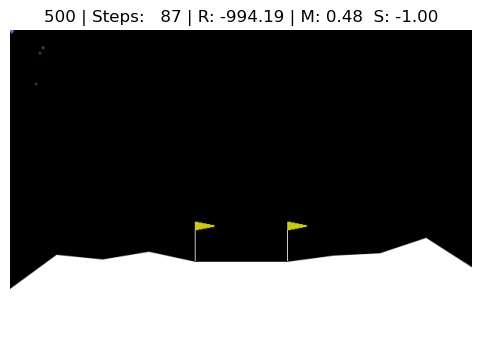

In [17]:
#### Display from DQN notebook
#chkpnt_name = "data/slvdpnt.pth"#"data/chkpnt{}.pth".format(chkpnt)  #
#agent.qnetwork_local.load_state_dict(torch.load(chkpnt_name))

# load the weights from file
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# watch a pre-trained agent
f = plt.figure(figsize=(10,4))
n=4
#for i in range(n):
for chkpnt in [100, 200, 400, 500]:
    chkpnt_name = "data/actor_chkpnt{}.pth".format(chkpnt)
    agent.actor_local.load_state_dict(torch.load(chkpnt_name))
    #chkpnt_name = "data/critic_chkpnt{}.pth".format(chkpnt)
    #agent.critic_local.load_state_dict(torch.load(chkpnt_name))
    score = 0
    state, _ = env.reset()
    img = plt.imshow(env.render())
    for j in range(1000):
        action = agent.act(state)
        state, reward, done, trun, _ = env.step(action)
        score += reward
        img.set_data(env.render()) 
        plt.axis('off')
        title = "{} | Steps: {:4d} | R: {:7.2f} | M: {:2.2f}  S: {:2.2f}".format(chkpnt, j+1, score, action[0], action[1])
        #title = "{} of {} | Step: {:4d} | Sum_Rs: {:7.2f} | Action: {:5s} ".format(i+1, n, j+1, score, num2act[action])
        plt.title(title)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done or trun:
            break 
print("Total episode reward: ", np.round(np.sum(score), 3))

In [ ]:
### action_noise array shape: (N,2,2) = (50000, (a0,a1), (n0,n1))
w = 100
action_noise = np.asarray(action_noise)
print("Action\n", action_noise[-w:,0,:], np.mean(action_noise[w:,0,:]))
print("Noise\n", action_noise[-w:,1,:], np.mean(action_noise[w:,1,:]))
print("Action+Noise\n", action_noise[-w:,0,:] + action_noise[-w:,1,:], np.mean(action_noise[w:,0,:] + action_noise[w:,1,:]))

In [ ]:
from agents import OUNoise
noizA = OUNoise(1, SEED, mu=0., theta=1.0, sigma=0.5)
noizE = OUNoise(1, SEED, mu=0., theta=1.0, sigma=-0.5)

noizezA=[]; noizezE=[]; noizez=[]
xvals = list(range(  1000  ))
for _ in xvals:
    noizezA += [noizA.sample()]
    noizezE += [0.5+noizE.sample()]
    noizez += [a+e for a,e in zip(noizA.sample(), noizE.sample())]
    #print(noizez[-1])
    # color='green', marker='o', linestyle='dashed',
print(np.mean(noizezA), np.mean(noizezE), np.mean(noizez))
#plt.plot(xvals, norm(noizezA), linewidth=0.4, markersize=0.5, alpha=0.75, c='#11d')
#plt.plot(xvals, norm(noizezE), linewidth=0.4, markersize=0.5, alpha=0.75, c='#d11')
plt.plot(xvals, noizezA-np.mean(noizezA), linewidth=0.4, markersize=0.5, alpha=0.75, c='#11d')
plt.plot(xvals, noizezE, linewidth=0.4, markersize=0.5, alpha=0.75, c='#d11')
#plt.plot(xvals, norm(noizez), linewidth=0.6, markersize=1.0, alpha=0.75, c='#111')

In [ ]:
norm(noizez)

#### Examples:

`Episode  100 | Average Score: -254.49 | Avg Steps:  118 | Epsilon: 0.606 | Buffer cycle:  11827 +  0

Episode  200 | Average Score: -104.40 | Avg Steps:  144 | Epsilon: 0.367 | Buffer cycle:  28800 +  0

Episode  300 | Average Score: -101.45 | Avg Steps:  223 | Epsilon: 0.222 | Buffer cycle:  66887 +  0

Episode  400 | Average Score:  -17.39 | Avg Steps:  402 | Epsilon: 0.135 | Buffer cycle:  60691 +  1

Episode  500 | Average Score:   36.90 | Avg Steps:  483 | Epsilon: 0.082 | Buffer cycle:  41366 +  2

Episode  600 | Average Score:   -2.30 | Avg Steps:  561 | Epsilon: 0.049 | Buffer cycle:  36642 +  3

Episode  700 | Average Score:  -11.75 | Avg Steps:  620 | Epsilon: 0.030 | Buffer cycle:  33737 +  4

Episode  800 | Average Score:   -0.93 | Avg Steps:  650 | Epsilon: 0.018 | Buffer cycle:  19645 +  5

Episode  900 | Average Score:   39.81 | Avg Steps:  678 | Epsilon: 0.011 | Buffer cycle:  10402 +  6

Episode 1000 | Average Score:  140.54 | Avg Steps:  673 | Epsilon: 0.010 | Buffer cycle:  73226 +  6

Episode 1100 | Average Score:  162.32 | Avg Steps:  652 | Epsilon: 0.010 | Buffer cycle:  17503 +  7

Episode 1166 | Episode Score:  258.97 | Eps Steps:  464 | Epsilon: 0.010 | Buffer cycle:  46212 +  7

Environment solved in 1066 episodes!	Average Score: 201.19

Episode 1200 | Average Score:  218.04 | Avg Steps:  635 | Epsilon: 0.010 | Buffer cycle:  61530 +  7`

In [ ]:
if False:
    #from collections import defaultdict
    data_dict = dict()
    #data_dict.update({"a_key":SEED})
    kee = "key"+str(0)
    for i in range(5):
        kee = "key"+str(i)
        data_dict.update({kee:(SEED*(1-1/((1+i)*10)))})
    data_dict.keys(), data_dict.values()
    #np.argmax#torch.clamp()
    randex = random.choices(list(agent.memory.priorities.keys()),
                            weights=list(agent.memory.priorities.values()), 
                            k=agent.memory.batch_size)

    priors=list(agent.memory.priorities.values())
    probs=[p/sum(priors) for p in priors]
    randnp = np.random.choice(list(agent.memory.priorities.keys()),
                              size=agent.memory.batch_size,
                              replace=False,
                              p=probs)
    len(randex)==len(set(randex)), len(randnp)==len(set(randnp))


In [ ]:
#torch.save(agent.actor_local.state_dict(), 'data/checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'data/checkpoint_critic.pth'))
#agent.actor_local.load_state_dict(torch.load('data/actor_chkpnt300.pth'))
#agent.critic_local.load_state_dict(torch.load('data/critic_chkpnt300.pth'))

critic_local_params = [p for p in agent.critic_local.parameters()]
critic_target_params = [p for p in agent.critic_target.parameters()]
print(critic_local_params[-1])
print(critic_target_params[-1])
#print(critic_local_params[0]==critic_target_params[0])

### Plots

In [ ]:
if True:
    # plot the scores
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, 'b.--', linewidth=0.5, markersize=1.0)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    #plt.xlim(0,25)
    plt.show()
else:
    # plot the normed scores
    norm = lambda x: (x - np.mean(x))/np.std(x) if np.std(x)!=0. else 0.
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), norm(np.asarray(scores)), 'c,--', linewidth=0.5, markersize=1.0,)
    plt.ylabel('Normed Score')
    plt.xlabel('Episode #')
    plt.show()

In [ ]:
# plot the episode_steps
score_per_step = [s/el for s, el in zip(scores, episode_lengths)]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_lengths)), score_per_step, 'g,--', linewidth=0.75, markersize=1.0,)
plt.plot(np.arange(len(scores)), norm(np.asarray(scores)), 'bo--', linewidth=0.25, markersize=1.0,)
plt.ylabel('Score / # Episode Steps')
plt.xlabel('Episode #')
plt.show()

(-1.0, 1.0)


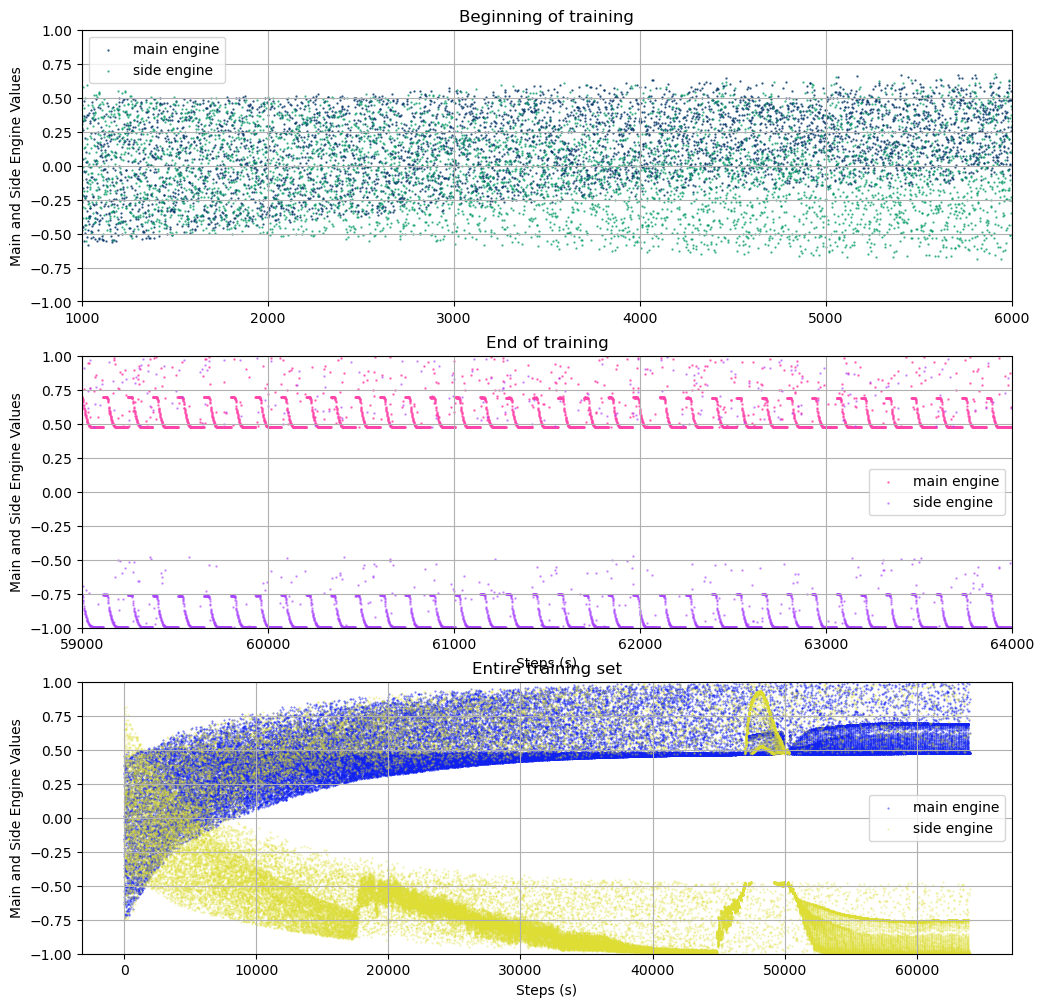

In [16]:
### Actions plot

#act=[(a[0],a[1]) for a in action_noise[:,0]]
#ion=[(n[0],n[1]) for n in action_noise[:,1]]

main_act= [a[0] for a in actions]
#main_ion= [n[0] for n in ion]
side_act= [a[1] for a in actions]
#side_ion= [n[1] for n in ion]

dim0= len(actions)
x = np.arange(0, dim0)
lim = dim0   #15000 #
xlims = (0, lim)
mylims = ( round(min(main_act[:lim] + side_act[:lim]), 2), round(max(main_act[:lim] + side_act[:lim]), 2) )
#mylims = ( round(min(main_act[:lim]), 2), round(max(main_act[:lim]), 2) )
print(mylims)
#sylims = ( round(min(side_act[:lim]), 2), round(max(side_act[:lim]), 2) )
#print(sylims)

plots=[]
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(311)
plt.ylabel('Main and Side Engine Values')
ax1.scatter(x, main_act, alpha=0.8, c='#036', s=0.4)#, linewidth=0.1, markersize=1.75
ax1.scatter(x, side_act, alpha=0.7, c='#096', s=0.4)#, linewidth=0.1, markersize=1.75
plt.title("Beginning of training")
plt.legend(["main engine","side engine"])
plt.ylim(*mylims)
plt.xlim(1000, 6000)   #(0, 12000)
plt.grid(visible=True)

ax2 = fig.add_subplot(312)
plt.ylabel('Main and Side Engine Values')
plt.xlabel('Steps (s)')
ax2.scatter(x, main_act, alpha=0.7, c='#f4a', s=0.6)
ax2.scatter(x, side_act, alpha=0.5, c='#a4f', s=0.6)
plt.title("End of training")
plt.legend(["main engine","side engine"])
plt.ylim(*mylims)
plt.xlim(lim-5000, lim)
plt.grid(visible=True)

ax3 = fig.add_subplot(313)
plt.ylabel('Main and Side Engine Values')
plt.xlabel('Steps (s)')
ax3.scatter(x, main_act, alpha=0.6, c='#12e', s=0.25)
ax3.scatter(x, side_act, alpha=0.4, c='#dd3', s=0.25)
plt.title("Entire training set")
plt.legend(["main engine","side engine"])
plt.ylim(*mylims)
plt.grid(visible=True)

plt.show()

In [ ]:
lims = (0,len(states))
plots = []
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(211)
plt.ylabel('States (high/low)')
#plt.xlabel('Steps (s)')
plt.xlim(11000, 21000)
#plt.xlim(*lims)
plots.append(ax1.plot(np.arange(len(states)), norm_np(states), linewidth=0.5, markersize=0.2, alpha=0.75))

ax2 = fig.add_subplot(212)
plt.ylabel('Next States (high/low)')
plt.xlabel('Steps (s)')
plt.xlim(lims[1]-40000,lims[-1])
#plt.xlim(*lims)
#ax1.sharex(ax2)
#ax2.sharex(ax1)
plots.append(ax2.plot(np.arange(len(next_states)), norm_np(next_states), linewidth=0.5, markersize=0.2, alpha=0.75))

In [ ]:
print([ a[1] for a in actions[-100:] ])# == next_states[-100:]

In [ ]:
###  plot noises
m_power = lambda m: (np.clip(m, 0.0, 1.0) + 1.0) * 0.5
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: np.tanh(x)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
mact= [a[0]-n[0] for a, n in zip(act, noi)]
mnoi= [n[0] for n in noi]
sact= [a[1]-n[1] for a, n in zip(act, noi)]
snoi= [n[1] for n in noi]
dim1= 6000#len(act) #action_noise.shape[0]
x= np.arange(1, dim1+1)
plt.plot(x, mnoi[1:dim1+1], linewidth=0.25, markersize=0.33, alpha=0.6, c='#00a')#
plt.plot(x, snoi[1:dim1+1], linewidth=0.25, markersize=0.33, alpha=0.6, c='#d44')
#plt.plot(x, mnoi, linewidth=0.1, markersize=0.3,)#, 
#plt.plot(x, snoi, linewidth=0.1, markersize=0.3,)
#[sigmoid(m) for m in main]
#[tanh(s) for s in side]
#plt.plot(np.arange(1, dim1+1), main[1:dim1+1], linewidth=0.25, markersize=0.33, alpha=0.33, c='#a00')#
#plt.plot(np.arange(1, dim1+1), side[1:dim1+1], linewidth=0.25, markersize=0.75, alpha=0.4, c='#911')#, 
ax.legend(["mact-mnoi","sact-snoi","main", "side"])
#plt.ylim(-2,1)
plt.ylabel('Functions(Actions)')
plt.xlabel('Step#')
plt.show()


In [ ]:
###  plot priorities
fig = plt.figure(figsize=(12,6))
priorities = [p for p in agent.memory.priorities.values()]
lim = len(priorities)
xlims = (0, lim)  #2000)
ylims = (( round(min(priorities[:lim])), round(max(priorities[:lim])) ))

ax = fig.add_subplot(111)
plt.plot(np.arange(0, len(priorities)), priorities, 'b.', linewidth=0.1, markersize=0.5, alpha=0.8)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.ylabel('Step Priority')
plt.xlabel('Step #')
plt.show()

## 4. Game-play & Animation

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
#torch.save(agent.actor_local.state_dict(), 'data/checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'data/checkpoint_critic.pth'))
agent.actor_local.load_state_dict(torch.load('data/actor_chkpnt300.pth'))
agent.critic_local.load_state_dict(torch.load('data/critic_chkpnt300.pth'))

actor_local_params = [p for p in agent.actor_local.parameters()]
actor_target_params = [p for p in agent.actor_target.parameters()]
print(actor_local_params[-1])
print(actor_target_params[-1])
#print(actor_local_params[0]==actor_target_params[0])

In [ ]:
# load the weights from file
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# watch a pre-trained agent

#for chkpnt in range(100,1300,300):
for chkpnt in [100,200,300,400,500]:    
    chkpnt_name = "data/actor_chkpnt{}.pth".format(chkpnt)
    agent.actor_local.load_state_dict(torch.load(chkpnt_name))
    score = 0
    state, _ = env.reset()
    img = plt.imshow(env.render())
    for j in range(1000):
        action = agent.act(state)
        state, reward, done, trun, _ = env.step(action)
        score += reward
        img.set_data(env.render()) 
        plt.axis('off')
        title = "C:{:4d} | S:{:4d} | R:{:7.2f} | M:{:4.3f} S:{:5.3f}".format(chkpnt, j+1, score, action[0], action[1])   #num2act[action])
        plt.title(title)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done or trun:
            break 

#env.close()

In [ ]:
chkpnt_name = "data/slvdpnt.pth"#"data/chkpnt{}.pth".format(chkpnt)  #
agent.qnetwork_local.load_state_dict(torch.load(chkpnt_name))
score = 0
state, _ = env.reset()
img = plt.imshow(env.render())
for j in range(1000):
    action = agent.act(state)
    state, reward, done, trun, _ = env.step(action)
    score += reward
    img.set_data(env.render()) 
    plt.axis('off')
    title = "{:6s} | {:5d} | {:8.2f} | {:7s}".format("Solved", j+1, score, num2act[action])
    plt.title(title)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done or trun:
        break 

In [ ]:
### Observe agent gameplay
pix_norm = lambda x: x/255.
SEED=1234
t = 500
smax = nn.Softmax(dim=1)

state, _ = env.reset(seed=SEED)
frame = env.render()
img = plt.imshow(pix_norm(frame))
action =  [random.random(), 2*random.random()-1]
for _ in range(t):
    state1, reward1, is_done, is_trunc, info = env.step(action)
    frame1 =  pix_norm(env.render())
    state2, reward2, is_done, is_trunc, info = env.step((0,0))
    frame2 =  pix_norm(env.render())
    states = np.asarray([scale_input(state1),
                         scale_input(state2)])
    action = [np.round(a,3) for a in agent.act(state2)]
    #pols = smax(sigs).detach().cpu().numpy()
    #probs = probs.detach().cpu().numpy()
    #action = np.argmax(probs[-1])
    
    #reward = reward2 + reward1
    
    frame = scale(frame2-frame1/2)
    img.set_data(frame)
    plt.title("M:"+str(action[0])+" S:"+str(action[1])+" R:"+str(np.round(reward1, 3)))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if is_done or is_trunc:
        break 

In [ ]:
m_powers = [(np.clip(a[0], 0.0, 1.0) + 1.0) * 0.5  for a in actions] ### 0.5..1.0 ### ??
[(a[0], mp) for a, mp in zip(actions, m_powers)]

# 5. To Do

"In this exercise, we have provided a sample DDPG agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks."
- **Amend the various hyperparameters and network architecture to solve the environment faster than this benchmark implementation.** 
  - Vary starting weights between locals and targets.

- Try to write an algorithm from scratch.

- Implement **prioritized experience replay** to see if it speeds learning.  

- Implement **parallel environments**

- The current implementation adds [Ornsetein-Uhlenbeck noise](https://blog.openai.com/better-exploration-with-parameter-noise/)  to the action space.  However, **adding noise to the parameters of the neural network policy can improve performance.**

- Explain in simple terms the intuition behind the DDPG algorithm and demonstrate how to use it to solve another continuous-action-space RL environment.  

## How well does DQN with Tile Coding how well does work?
* Reuse DQN from Project 1, but use Tile Coding to turn continuous into discrete actions
* Implement improvements on DQN from Project 1 first